<a id='home'></a>
### purpose 

- create the files that will be needed to run the R script created in `../05_gradient_forest_processing_scripts.ipynb` for all permutations of `loci set x input populations` created here
- in other words, the allele frequency for each loci set and environmental data for each population set will be subset for the populations randomly selected for training (see `../01_split_training_and_testing.ipynb`) and the loci sets created in this notebook


### outline

[1. load allele frequency data](#freqs)
- read in filtered SNP sets in parallel, for each job convert % to float and drop irrelevant columns

[2. load outliers and select random loci two ways (random and pseudo random)](#outliers)
- determine snps found in WZA genes
    - take top 100 ranked WZA genes from each environment, keep loci within genes with Kendall's tau > 0.5 to any environment
- get baypass outliers ≥ 15
- get loci that had tau ≤ 0.1 for all envs - this is the non-outlier set
- for the set of loci from wza and baypass, randomly choose the same number of loci from the non-outlier set (a pseudorandom set) and from a truly random set (whole dataset genome wide)
    - pseudorandom set should be what we DONT want to give these offset methods

[3. load environmental data](#envdata)
- load the raw environmental data to get each pop's lat/long

[4. load training data](#training)
- for the populations that were chosen for training sets for each of the kfold cross validations (from `01_split_training_and_testing.ipynb`), subset the frequency data and envdata for these pops
- save these training sets to file

[5. create HPC slurm files to run scripts for each permutation](#slurm)
- create the necessary sbatch.sh files to run scripts


[6. transfer to HPC (cedar)](#cedar)
- rsync all needed files to HPC, execute on HPC

### Notes

- this will need to be rerun to get the WL baypass results (not yet done, probably won't happen)
- models across both varieties of doug-fir were loci from combined snp calling** that intersected with:
    - coastal + interior baypass
    - coastal + interior wza loci
    - except for the random/pseudo random sets which were random with respect to non_outliers and genome wide (ie these were not any deliberate combination of coastal + interior)
    
\** combined snp calling is calling SNPs across both varieties, and implementing filtering as usual (<25% missing data across all pops (both varieties), etc)

In [1]:
from pythonimports import *

DIR = '/data/projects/pool_seq/phenotypic_data/offset_misc_files'

lview,dview = get_client()

latest_commit()
sinfo(html=True)

56 56
##################################################################
Current commit of pythonimports:
commit 0f67fe16b545ed556fd3ce2d4b01565e7a24831a  
Author: Brandon <brandon.lind@ubc.ca>  
Date:   Thu Jul 15 11:38:49 2021 -0600
Today:	July 23, 2021 - 23:29:21
python version: 3.8.5
##################################################################



In [2]:
# see end of notebook for run time
t1 = dt.now()

<a id='freqs'></a>
# 1. load allele freqs

- gradient forests wants allele freqs, varscan outputs percentages, convert in parallel

[top](#home)

In [3]:
def frequenize(df):
    """Convert allele freq percent to float."""
    # convert percentage to float
    import pandas 

    locuscol = 'unstitched_locus' if 'unstitched_locus' in df.columns.tolist() else 'locus'
    
    freqcols = [col for col in df.columns if 'FREQ' in col]
    
    df.index = df[locuscol].tolist()
    df = df[freqcols].apply(lambda row: row.str.rstrip("%").astype(float)/100, axis=1)
    df.columns = [col.rstrip(".FREQ") for col in df.columns]

    return df

In [4]:
# these are the full sets of MAF-filtered loci
snp_files = {
    'fdc': '/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety_with-p6/03_maf-p05_RD-recalculated_FDC/DF_pooled-varscan_all_bedfiles_SNP_FDC_maf_RD-recalculated.txt',
    'fdi': '/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety_without-p6/03_maf-p05_RD-recalculated_FDI/DF_pooled-varscan_all_bedfiles_SNP_FDI_maf_RD-recalculated.txt',
    'jp': '/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/without_p24/03_maf-p05_RD-recalculated/JP_pooled-varscan_all_bedfiles_SNP_without-p24_maf_RD-recalculated.txt',
    'wl': '/data/projects/pool_seq/WL_genome_tests/WL_psuedo/WL_pseudo_all/snpsANDindels/03_maf-p05_RD-recalculated/WL_pseudo-varscan_all_bedfiles_SNP_maf_RD-recalculated.txt',
    'combined': '/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/combined_varieties/03_maf-p05_RD-recalculated_both/DF_pooled-varscan_all_bedfiles_SNP_both-varieties_maf_RD-recalculated.txt'
}

In [5]:
# read in each snp file in parallel, each job convert % to float for each allele freq in chunk, throw out all other info
snps = {}
for spp,file in snp_files.items():
    snps[spp] = parallel_read(file,
                              lview=lview,
                              dview=dview,
                              verbose=False,
                              functions=create_fundict(frequenize),
                              reset_index=False)
    print(spp, nrow(snps[spp]))


Watching 56 parallel_read() jobs ...


DF_pooled-varscan_all_bedfiles_SNP_FDC_maf_RD-recalculated.txt: 100%|██████████| 56/56 [00:57<00:00,  1.03s/it]


Function `parallel_read` completed after : 0-00:01:10
fdc 2254116

Watching 56 parallel_read() jobs ...


DF_pooled-varscan_all_bedfiles_SNP_FDI_maf_RD-recalculated.txt: 100%|██████████| 56/56 [01:01<00:00,  1.10s/it]


Function `parallel_read` completed after : 0-00:01:14
fdi 2483660

Watching 56 parallel_read() jobs ...


JP_pooled-varscan_all_bedfiles_SNP_without-p24_maf_RD-recalculated.txt: 100%|██████████| 56/56 [00:29<00:00,  1.87it/s]


Function `parallel_read` completed after : 0-00:00:40
jp 1163236

Watching 56 parallel_read() jobs ...


WL_pseudo-varscan_all_bedfiles_SNP_maf_RD-recalculated.txt: 100%|██████████| 56/56 [00:39<00:00,  1.40it/s]


Function `parallel_read` completed after : 0-00:00:52
wl 1465277

Watching 56 parallel_read() jobs ...


DF_pooled-varscan_all_bedfiles_SNP_both-varieties_maf_RD-recalculated.txt: 100%|██████████| 56/56 [01:34<00:00,  1.69s/it]


Function `parallel_read` completed after : 0-00:01:51
combined 2767766


<a id='outliers'></a>
# 2. load outliers and random loci
- baypass
- wza
- random

[top](#home)

### WZA

First, isolate the top 100 WZA genes for each env, then subset the loci within these genes for any loci with Kendall's tau > 0.5

##### Get WZA genes

In [6]:
wzadir = '/data/projects/convergence/WZA/north_america'
wzadirs = [op.join(wzadir, spp) for spp in ['DFC', 'DFI', 'JP/v2', 'WL']]
wzadirs

['/data/projects/convergence/WZA/north_america/DFC',
 '/data/projects/convergence/WZA/north_america/DFI',
 '/data/projects/convergence/WZA/north_america/JP/v2',
 '/data/projects/convergence/WZA/north_america/WL']

In [7]:
# get the files that rank genes by environment
wza_files = {}
for spp,d in zip(['fdc', 'fdi', 'jp', 'wl'], wzadirs):
    env_files = fs(d, endswith='OG', exclude=['LONG', 'Long', 'Lat', 'LAT'])  # 19 climate envs + elevation
    print(spp, op.basename(d), len(env_files))
    wza_files[spp] = env_files

fdc DFC 20
fdi DFI 20
jp v2 20
wl WL 20


In [8]:
# make sure all envs overlap among files
wza_envs = defaultdict(list)
for spp,files in wza_files.items():
    for f in files:
        species = spp if spp != 'jp' else 'JP'
        env = op.basename(f).split(f"_{species}")[0].split("_df")[0]
#         print(spp, env)
        wza_envs[spp].append(env)
for i,sppi in enumerate(wza_envs.keys()):
    for j,sppj in enumerate(wza_envs.keys()):
        if i < j:
            print(sppi, sppj, len(set(wza_envs[sppi]).intersection(wza_envs[sppj])))

fdc fdi 20
fdc jp 20
fdc wl 20
fdi jp 20
fdi wl 20
jp wl 20


In [9]:
# # get the top 100 WZA genes by taking the abs(Z-score) of the WZA statistic

cutoff = 100
wza_dfs = defaultdict(dict)
for spp,files in wza_files.items():
    if spp=='fdi':
        spp2 = 'fdi'
    elif spp=='fdc':
        spp2 = 'fdc'
    elif spp=='jp':
        spp2 = spp
    elif spp=='wl':
        spp2 = 'wl'
    if spp in ['dfc', 'dfi']:
        raise Exception("I don't like these labels")
    count = None
    for f in pbar(files, desc=spp):
        species = spp if spp == 'wl' else 'JP' if spp == 'jp' else 'dfc' if spp == 'fdc' else 'dfi'
        env = op.basename(f).split(f"_{species}")[0]
        df = pd.read_table(f)
#         cutoff = math.floor(0.01 * nrow(df))
        df['Z_empP'] = df['Z_empP'].abs()
        wza_dfs[spp2][env] = df.sort_values(by='Z_empP', ascending=False).iloc[:cutoff].reset_index(drop=True)
        # assert each env has the same number of outliers
        if count is None:
            count = nrow(df)
        else:
            assert count == nrow(df)
    del spp2
    
# add to combined (coastal + interior) - use top 100 from each variety
for env,df in pbar(wza_dfs['fdc'].items(), desc='combined'):
    fdidf = wza_dfs['fdi'][env.replace("dfc", "dfi")]
    fdcgenes = set(df['gene'])
    # if i don't subtract fdcgenes, then the dfs I get back will have duplicated genes
    fdigenes = set(fdidf['gene']) - set(fdcgenes)
    cdf = pd.concat(
        [df[df['gene'].isin(fdcgenes)],
         fdidf[fdidf['gene'].isin(fdigenes)]]
    ).reset_index(drop=True)
    
    assert luni(cdf['gene']) == nrow(cdf)
    
    wza_dfs['combined'][env]  = cdf
    
wza_dfs['combined'][env].head()

combined: 100%|██████████| 20/20 [00:00<00:00, 302.31it/s]


,gene,pos,Z_p_weiZ_num,Z_p_weiZ_den,Z_p,Z_empP_weiZ_num,Z_empP_weiZ_den,Z_empP,hits,SNPs,gene_start,gene_end,contig,env,top_candidate_p,expected_hits,orthogroup,num_genes_in_OG
0,ID=cyclic_GFFY01002131.1.path1;Name=cyclic_GFF...,240554.533333,49.510506,1.764782,28.054751,46.487452,1.764782,26.341760,71,105,237743,242560,jcf7190000017475,eFFP,3.533829e-75,13.0,NaN,0
1,PSME_42677,268710.771812,38.477361,1.864987,20.631440,34.517591,1.864987,18.508223,30,149,252090,276085,jcf7190000028831,eFFP,4.183740e-14,16.0,OG0002947,3
2,PSME_34318,827615.324675,32.009121,1.781055,17.971999,28.985854,1.781055,16.274541,30,77,824719,918841,jcf7190000007175,eFFP,4.752330e-23,11.0,OG0024793,1
3,ID=cyclic_GAZW02076644.1.path1;Name=cyclic_GAZ...,312272.979167,42.004877,2.424882,17.322445,37.139074,2.424882,15.315830,14,96,310305,338870,jcf7190000157797,eFFP,1.290048e-05,12.0,OG0000720,9
4,ID=wasp_MSTRG.55797.1_MSTRG.55797.path1;Name=w...,64117.195312,24.060308,1.475624,16.305181,21.215001,1.475624,14.376974,20,128,61297,65799,jcf7190000152123,eFFP,6.247118e-08,14.0,OG0021140,1


In [10]:
for spp,envdict in wza_dfs.items():
    for env,df in envdict.items():
        print(spp, env, nrow(df))

fdc AHM 100
fdc CMD 100
fdc DD5 100
fdc DD_0 100
fdc EMT 100
fdc EXT 100
fdc Elevation 100
fdc Eref 100
fdc FFP 100
fdc MAP 100
fdc MAT 100
fdc MCMT 100
fdc MSP 100
fdc MWMT 100
fdc NFFD 100
fdc PAS 100
fdc SHM 100
fdc TD 100
fdc bFFP 100
fdc eFFP 100
fdi AHM 100
fdi CMD 100
fdi DD5 100
fdi DD_0 100
fdi EMT 100
fdi EXT 100
fdi Elevation 100
fdi Eref 100
fdi FFP 100
fdi MAP 100
fdi MAT 100
fdi MCMT 100
fdi MSP 100
fdi MWMT 100
fdi NFFD 100
fdi PAS 100
fdi SHM 100
fdi TD 100
fdi bFFP 100
fdi eFFP 100
jp AHM 100
jp CMD 100
jp DD5 100
jp DD_0 100
jp EMT 100
jp EXT 100
jp Elevation 100
jp Eref 100
jp FFP 100
jp MAP 100
jp MAT 100
jp MCMT 100
jp MSP 100
jp MWMT 100
jp NFFD 100
jp PAS 100
jp SHM 100
jp TD 100
jp bFFP 100
jp eFFP 100
wl AHM 100
wl CMD 100
wl DD5 100
wl DD_0 100
wl EMT 100
wl EXT 100
wl Elevation 100
wl Eref 100
wl FFP 100
wl MAP 100
wl MAT 100
wl MCMT 100
wl MSP 100
wl MWMT 100
wl NFFD 100
wl PAS 100
wl SHM 100
wl TD 100
wl bFFP 100
wl eFFP 100
combined AHM 198
combined CMD 19

In [11]:
# get a list of the unique wza genes across envs (for asserting correct annotation later on)
wza_genes = defaultdict(set)
for spp,envdfs in wza_dfs.items():
    for env,envdf in envdfs.items():
        if len(wza_genes[spp]) == 0:
            wza_genes[spp] = envdf['gene'].tolist()
        else:
            wza_genes[spp] = set(list(wza_genes[spp]) + envdf['gene'].tolist())
    print(spp, len(wza_genes[spp]))

fdc 554
fdi 644
jp 488
wl 829
combined 1139


##### determine loci within WZA genes by annotating loci with gene start/stops

In [12]:
# get genome annotation files
# (dfi and dfc get the same gff)
gffs = {
    'fdc' : '/data/projects/convergence/annotation/DF.merged.final.gff.genes.independent.forWZA',
    'jp' : '/data/projects/convergence/annotation/Pine.merged.final.gff.genes.independent.forWZA',
}

# all doug-fir and wl species use the same reference 
gffs['fdi'] = gffs['fdc']
gffs['wl'] = gffs['fdc']
gffs['combined'] = gffs['fdc']

gffs

{'fdc': '/data/projects/convergence/annotation/DF.merged.final.gff.genes.independent.forWZA',
 'jp': '/data/projects/convergence/annotation/Pine.merged.final.gff.genes.independent.forWZA',
 'fdi': '/data/projects/convergence/annotation/DF.merged.final.gff.genes.independent.forWZA',
 'wl': '/data/projects/convergence/annotation/DF.merged.final.gff.genes.independent.forWZA',
 'combined': '/data/projects/convergence/annotation/DF.merged.final.gff.genes.independent.forWZA'}

In [13]:
# convert lists of loci in to dataframes with columns = ['CHROM', 'POS', 'LOCUS']
loci_tables = {}
for spp,df in pbar(snps.items()):
    locusdf = pd.DataFrame(df.index.tolist(), columns=['locus'])
    df2 = locusdf['locus'].str.split("-", expand=True)
    df2.columns = ['contig', 'pos']
    df2['locus'] = df.index.tolist()
    loci_tables[spp] = df2

df2.head()

100%|██████████| 5/5 [00:29<00:00,  5.87s/it]


,contig,pos,locus
0,jcf7190000000000,77657,jcf7190000000000-77657
1,jcf7190000000000,77738,jcf7190000000000-77738
2,jcf7190000000000,77764,jcf7190000000000-77764
3,jcf7190000000004,54418,jcf7190000000004-54418
4,jcf7190000000004,54505,jcf7190000000004-54505


In [14]:
def get_wza_loci(chunk, spp):
    """For each `chunk` of a parallelized snptable, annotate any loci in the top # of WZA genes in `wza_dfs`.
    
    Returns
    -------
    a dataframe with the annotated loci, and columns for each env that gene was an outlier
    """
    from tqdm import tqdm as pbar
    import pandas as pd
    import numpy as np
    
    # create a dataframe for loci in `chunk`, with columns : CHROM, POS, LOCUS
    locuscol = 'unstitched_locus' if 'unstitched_locus' in chunk.columns.tolist() else 'locus'
    if spp == 'wl':
        # wza team forgot to used unstitched pos, i'll have to translate later
        locuscol = 'locus'
    locusdf = pd.DataFrame(chunk[locuscol].tolist(), columns=['locus'])
    locus_table = locusdf['locus'].str.split("-", expand=True)
    locus_table.columns = ['contig', 'pos']
    locus_table['locus'] = locusdf['locus'].tolist()
    locus_table['gene'] = np.nan
    if spp == 'wl':
        locus_table['unstitched_contig'] = chunk['unstitched_chrom'].tolist()
        locus_table['unstitched_pos'] = chunk['unstitched_pos'].tolist()
        locus_table['unstitched_locus'] = chunk['unstitched_locus'].tolist()
    
    # annotate loci with wza outlier genes
    for env,env_df in wza_dfs[spp].items():
        if spp=='jp':
            # the wza files stripped the '>' at the front of contig names
            env_df['contig'] = '>' + env_df['contig']

        # reduce wza output to contigs in `chunk`
        env_df = env_df[env_df['contig'].isin(locus_table['contig'])]
        
        # annotate any loci that are within the bounds of the genes' (rows) start/stop given in the WZA output
        locus_table[env] = False
        for row in pbar(env_df.index, desc=env):
            gene_ID,numloci,start,stop,contig = env_df.loc[row,
                                                           ['gene', 'SNPs', 'gene_start', 'gene_end', 'contig']]
            df = locus_table[locus_table['contig'] == contig]
            df = df[(df['pos'].astype(int) >= start) & (df['pos'].astype(int) <= stop)]
            if nrow(df) > 0:
                locus_table.loc[df.index, 'gene'] = gene_ID
                locus_table.loc[df.index, env] = True

    # only keep loci that are in wza outlier genes - ie those that I annotated in loop just above
    wza_loci = locus_table[locus_table['gene'].notnull()].copy()
    
    # clean up WL
    if spp == 'wl':
        # overwrite columns for computational ease downstream
        wza_loci['contig'] = wza_loci['unstitched_contig']
        wza_loci['pos'] = wza_loci['unstitched_pos']
        wza_loci['locus'] = wza_loci['unstitched_locus']
        # remove redundant columns
        wza_loci.pop('unstitched_contig')
        wza_loci.pop('unstitched_pos')
        wza_loci.pop('unstitched_locus')

    wza_loci.index = wza_loci['locus'].tolist()
    
    return wza_loci

dview['wza_dfs'] = wza_dfs
dview['nrow'] = nrow

In [15]:
# wait for `wza_dfs` to load to engines - watching `top` memory used in another terminal
sleeping(60)

sleeping: 100%|██████████| 60/60 [01:00<00:00,  1.00s/it]


In [16]:
# read in each snp file in parallel, annotate loci in chunk (if applicable), return annotated loci (or blank df)
wza_loci = {}
for spp,file in snp_files.items():
    wza_loci[spp] = parallel_read(file,
                                  lview=lview,
                                  dview=dview,
                                  verbose=False,
                                  functions=create_fundict(get_wza_loci,
                                                           args={'spp' : spp}),
                                  assert_rowcount=False,
                                  reset_index=False)

    # check if the number of genes that annotated loci are the same number as I expected
    print(spp,
          luni(wza_loci[spp]['gene']),
          len(wza_genes[spp]),
          nrow(wza_loci[spp]))
    
    assert luni(wza_loci[spp]['gene']) == len(wza_genes[spp])


Watching 56 parallel_read() jobs ...


DF_pooled-varscan_all_bedfiles_SNP_FDC_maf_RD-recalculated.txt: 100%|██████████| 56/56 [00:22<00:00,  2.44it/s]


Function `parallel_read` completed after : 0-00:00:37
fdc 554 554 49069

Watching 56 parallel_read() jobs ...


DF_pooled-varscan_all_bedfiles_SNP_FDI_maf_RD-recalculated.txt: 100%|██████████| 56/56 [00:22<00:00,  2.44it/s]


Function `parallel_read` completed after : 0-00:00:37
fdi 644 644 62442

Watching 56 parallel_read() jobs ...


JP_pooled-varscan_all_bedfiles_SNP_without-p24_maf_RD-recalculated.txt: 100%|██████████| 56/56 [00:11<00:00,  4.70it/s]


Function `parallel_read` completed after : 0-00:00:23
jp 488 488 28152

Watching 56 parallel_read() jobs ...


WL_pseudo-varscan_all_bedfiles_SNP_maf_RD-recalculated.txt: 100%|██████████| 56/56 [00:17<00:00,  3.21it/s]


Function `parallel_read` completed after : 0-00:00:30
wl 829 829 55169

Watching 56 parallel_read() jobs ...


DF_pooled-varscan_all_bedfiles_SNP_both-varieties_maf_RD-recalculated.txt: 100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


Function `parallel_read` completed after : 0-00:01:07
combined 1139 1139 114891


In [17]:
wza_loci['combined'].head()

,contig,pos,locus,gene,AHM,CMD,DD5,DD_0,EMT,EXT,Elevation,Eref,FFP,MAP,MAT,MCMT,MSP,MWMT,NFFD,PAS,SHM,TD,bFFP,eFFP
jcf7190000000037-13058,jcf7190000000037,13058,jcf7190000000037-13058,PSME_41321,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True,True
jcf7190000000037-13069,jcf7190000000037,13069,jcf7190000000037-13069,PSME_41321,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True,True
jcf7190000000037-13084,jcf7190000000037,13084,jcf7190000000037-13084,PSME_41321,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True,True
jcf7190000000037-13204,jcf7190000000037,13204,jcf7190000000037-13204,PSME_41321,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True,True
jcf7190000000037-13254,jcf7190000000037,13254,jcf7190000000037-13254,PSME_41321,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True,True


In [18]:
# make sure I got the same number of loci from annotating as I would expect given data in the WZA files
# sum the number of SNPs in each of the unique genes across envs in WZA files, compare to number of annotated loci
# because WZA wasn't done across both varieties, I ignore this assertion for the 'combined' set
    # this is because the set of loci for {coastal and interior} != {combined} due to filtering
for spp in snp_files.keys():
    gene_snpcounts = {}
    for env,wzadf in wza_dfs[spp].items():
        wzadf = wzadf[wzadf['gene'].isin(wza_genes[spp])]
        gene_snpcounts.update(dict(
            zip(wzadf['gene'], wzadf['SNPs'].astype(int))
        ))
    numsnps = sum(gene_snpcounts.values())  # sum the number of SNPs in each of the unique genes from WZA files
    if spp != 'combined':
        assert numsnps == nrow(wza_loci[spp])
    print(spp, numsnps, nrow(wza_loci[spp]))

fdc 49069 49069
fdi 62442 62442
jp 28152 28152
wl 55169 55169
combined 102549 114891


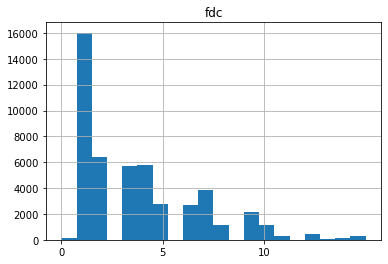

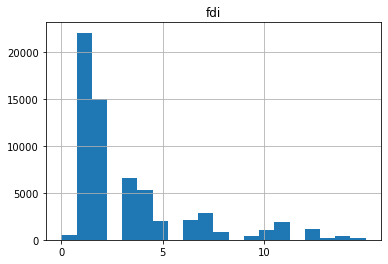

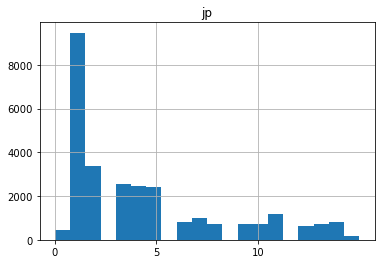

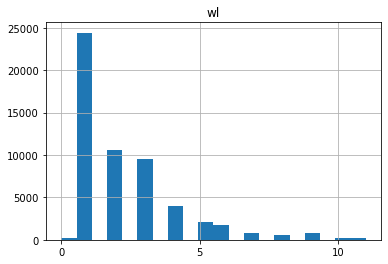

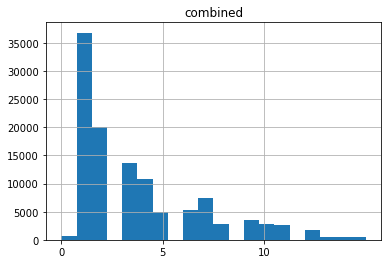

In [19]:
# how many times was a given gene associated to X number of envs? 
# - this actually counts loci, not genes (but loci are within genes so shape of hist should be consistent)
for spp,locidf in wza_loci.items():
    locidf['sums'] = locidf[locidf.columns.tolist()[-19:]].apply(lambda envcounts: sum(envcounts), axis=1)
    locidf['sums'].hist(bins=20)
    plt.title(spp)
    try:
        plt.xticks(range(0,
                         locidf['sums'].max(),
                         5))
    except TypeError as e:
        fail_msg = f'******* error for {spp} *******'
        border = '*' * len(fail_msg)
        print(ColorText(f'{border}\n{fail_msg}\n{border}').fail().bold())
    plt.show()

In [20]:
# get list of loci in the top WZA genes - never used
wza_all = {}
for spp,df in wza_loci.items():
    wza_all[spp] = df['locus'].tolist()
    perc = round(nrow(df) / nrow(snps[spp]), 4)*100
    print(spp, nrow(df), f'{perc}%')

fdc 49069 2.18%
fdi 62442 2.5100000000000002%
jp 28152 2.42%
wl 55169 3.7699999999999996%
combined 114891 4.15%


In [21]:
# translate WL stitched to unstitched position (wza team accidentally used stitched position)

def translate(df):
    """Translate WL stitched to unstitched locus names."""
    return dict(zip(df['locus'], df['unstitched_locus']))

dicts = parallel_read(
    snp_files['wl'],
    lview=lview,
    dview=dview,
    verbose=False,
    maintain_dataframe=False,
    functions=create_fundict(translate)
)

wl_trans = {}
counts = 0
for d in dicts:
    wl_trans.update(d)
    counts += len(d)
len(wl_trans), counts


Watching 56 parallel_read() jobs ...


WL_pseudo-varscan_all_bedfiles_SNP_maf_RD-recalculated.txt: 100%|██████████| 56/56 [00:16<00:00,  3.30it/s]


Function `parallel_read` completed after : 0-00:00:28


(1465277, 1465277)

##### reduce loci within wza top 100 genes to those with Kendall's tau > 0.5

In [22]:
wzadirs

['/data/projects/convergence/WZA/north_america/DFC',
 '/data/projects/convergence/WZA/north_america/DFI',
 '/data/projects/convergence/WZA/north_america/JP/v2',
 '/data/projects/convergence/WZA/north_america/WL']

In [23]:
# reduce wza input to those loci with tau > 0.5, reduce further to the set of loci in top WZA genes
def read_tau_table(tau_table, sep='\t'):
    """Read in input to WZA with scores for each locus, return those with abs(Kendall's Tau) > 0.5."""
    return tau_table[tau_table['kendallstau'].abs() > 0.5].reset_index(drop=True)


wza = {}
for spp,d in zip(['fdc', 'fdi', 'jp', 'wl'], wzadirs):
    files = fs(d, pattern='kendallstau')
    assert len(files) == 1
    
    # read in kendall's tau results
    taudf = parallel_read(files[0],
                          lview=lview,
                          dview=dview,
                          verbose=False,
                          assert_rowcount=False,
                          functions=create_fundict(read_tau_table),
                          desc=spp)
    if spp in ['jp', 'wl']:
        # append '>' before locus name
        outliers = ('>' + taudf['snp']).tolist()
    else:
        outliers = taudf['snp'].tolist()

    # get the outliers we care about - those in top wza genes
    wza[spp] = list(set(outliers).intersection(wza_loci[spp]['locus']))

    if spp == 'wl':
        # translate to unstitched positions - wza team used stitched
        wza[spp] = [wl_trans[locus.replace('>', '')] for locus in wza[spp]]
        outliers = [wl_trans[locus.replace('>', '')] for locus in outliers]

    # make sure numbers make sense - I should be able to find all of the outliers in the snp table
        # this will ensure that they should be in the annotated loci that fall witin WZA genes
    assert len(set(outliers).intersection(snps[spp].index)) == luni(outliers)
    
    print(spp, len(wza[spp]))


Watching 56 parallel_read() jobs ...


fdc: 100%|██████████| 56/56 [00:33<00:00,  1.69it/s]


Function `parallel_read` completed after : 0-00:01:08
fdc 4886

Watching 56 parallel_read() jobs ...


fdi: 100%|██████████| 56/56 [00:37<00:00,  1.50it/s]


Function `parallel_read` completed after : 0-00:01:15
fdi 11434

Watching 56 parallel_read() jobs ...


jp: 100%|██████████| 56/56 [00:15<00:00,  3.60it/s]


Function `parallel_read` completed after : 0-00:00:36
jp 4788

Watching 56 parallel_read() jobs ...


wl: 100%|██████████| 56/56 [00:28<00:00,  1.97it/s]


Function `parallel_read` completed after : 0-00:00:56
wl 8496


In [24]:
# combine interior and coastal, reduce to those loci called across varities
wza['combined'] = list(set(
    wza['fdc'] + wza['fdi']
).intersection(
    snps['combined'].index.tolist()
))

print('combined', len(wza['combined']))

combined 14760


### non-outliers (pseudo random)

- these are loci that have kendall's tau < 0.1 for ALL envs
- I'll choose randomly among these loci to match sample sizes in WZA (above) and baypass (below)
- truly random loci (without respect to outlier status) are chosen after baypass below

In [25]:
def get_non_outliers(tau_table):
    """Return only loci that have Kendall's Tau < 0.1.
    
    `tau_table` is the input to the WZA test.
    """
    return tau_table[tau_table['kendallstau'] < 0.1]

# my 20 envs that I'm using to train gradient forest
envs = ['Elevation', 'AHM', 'CMD', 'DD5', 'DD_0', 'EMT', 'EXT', 'Eref', 'FFP', 'MAP',
        'MAT', 'MCMT', 'MSP', 'MWMT', 'NFFD', 'PAS', 'SHM', 'TD', 'bFFP', 'eFFP']
assert len(envs) == 20


non_outliers = {}
for spp,d in zip(['fdc', 'fdi', 'jp', 'wl'], wzadirs):
    files = fs(d, pattern='kendallstau')
    assert len(files) == 1
    
    # read in kendall's tau results
    taudf = parallel_read(files[0],
                          lview=lview,
                          dview=dview,
                          verbose=False,
                          assert_rowcount=False,
                          functions=create_fundict(get_non_outliers),
                          desc=spp)

    # make sure all 20 envs are in the df, reduce tau results to only those envs
    assert sum(pd.Series(envs).isin(taudf['env'])) == 20
    taudf = taudf[taudf['env'].isin(envs)]
    
    # find loci that have low tau across all envs
    # (if tau < 0.1 for a locus for all envs, a locus should occur 20 times in the full filtered tau_table 
        # - I have 20 envs)
    locus_counter = Counter(taudf['snp'])
    low_tau = [locus for (locus,count) in locus_counter.items() if count == 20]
    
    # clean up locus names
    if spp in ['jp', 'wl']:
        # append '>' before locus name
        low_tau = ['>' + locus for locus in low_tau]
    if spp == 'wl':
        # translate to unstitched positions - wza team used stitched
        low_tau = [wl_trans[locus.replace('>', '')] for locus in low_tau]
        
    # make sure numbers make sense - I should be able to find all of the outliers in the snp table
        # this will ensure that they should be in the annotated loci that fall within WZA genes
    assert len(set(low_tau).intersection(snps[spp].index)) == luni(low_tau)
    
    non_outliers[spp] = uni(low_tau)
    print(spp, len(non_outliers[spp]))
    

# combine coastal and interior, reduce to those SNPs called across varieities    
non_outliers['combined'] = list(set(
    non_outliers['fdi'] + non_outliers['fdc']
).intersection(snps['combined'].index.tolist()))
print('combined', len(non_outliers['combined']))


Watching 56 parallel_read() jobs ...


fdc: 100%|██████████| 56/56 [00:35<00:00,  1.58it/s]


Function `parallel_read` completed after : 0-00:01:11
fdc 169760

Watching 56 parallel_read() jobs ...


fdi: 100%|██████████| 56/56 [00:37<00:00,  1.49it/s]


Function `parallel_read` completed after : 0-00:01:16
fdi 85903

Watching 56 parallel_read() jobs ...


jp: 100%|██████████| 56/56 [00:17<00:00,  3.25it/s]


Function `parallel_read` completed after : 0-00:00:42
jp 72241

Watching 56 parallel_read() jobs ...


wl: 100%|██████████| 56/56 [00:26<00:00,  2.10it/s]


Function `parallel_read` completed after : 0-00:00:56
wl 33263
combined 200635


In [26]:
non_copy = copy.deepcopy(non_outliers)

### baypass

for each species
- get lists of baypass outliers with mean_BF(dB) ≥ 15

In [27]:
def find_outliers(spp, pkl):
    """For a given species, get baypass outliers with mean_BF ≥ 15.
    
    Also get non-outliers for loci with mean_BF < 1 for ALL envs.
    
    Notes
    -----
    - each pkl is a dictionary with keys for environment and values as baypass output
        - these files were created in each species' baypass/gather notebook
    """
    from pythonimports import pklload, uni
    from tqdm import tqdm as pbar
    
    results = pklload(pkl)
    
    outliers = []  # loci that have BF ≥ 15 for any of the envs
    for i,(env,df) in enumerate(pbar(results.items())):
        gte15 = df.index[df['mean_BF(dB)'] >= 15].tolist()  # greater than or equal to 15
        outliers.extend(gte15)
        
    outliers = uni(outliers)
    
    return spp, outliers

In [28]:
# get outlier sets in parallel
jobs = []
for spp,file in snp_files.items():
    if spp in ['wl', 'combined']:
        # no baypass results
        continue
    d = op.dirname(file)
    pkl = op.join(d, 'baypass/final_results/envdfs_after_ranking.pkl')
    jobs.append(
        lview.apply_async(
            find_outliers, *(spp, pkl)
        )
    )
watch_async(jobs)

# retrieve parallel job info
print('spp cands non-candidates')
baypass = {}
for j in jobs:
    spp, candidates = j.r
    baypass[spp] = candidates
    print(spp, len(candidates))
    
# combine coastal and interior, reduce to those SNPs called across varieties
spp = 'combined'
baypass[spp] = list(set(
    baypass['fdc'] + baypass['fdi']
).intersection(snps[spp].index.tolist()))
print(spp, len(baypass[spp]))


Watching 3 jobs ...


100%|██████████| 3/3 [00:25<00:00,  8.44s/it]


spp cands non-candidates
fdc 17516
fdi 12398
jp 22635
combined 25219


In [29]:
# compare with wza
for spp,loci in wza.items():
    print(spp, len(loci))
# fdc 4886
# fdi 11434
# jp 4788
# wl 8496

fdc 4886
fdi 11434
jp 4788
wl 8496
combined 14760


In [30]:
keys(baypass)

['fdc', 'fdi', 'jp', 'combined']

In [31]:
keys(wza)

['fdc', 'fdi', 'jp', 'wl', 'combined']

### pseudo random loci (randomly chosen among non-outliers)
random non-outlier loci sets of the same size as wza and baypass

In [32]:
# previously set seeds (i may add in wl_baypass at a later date, and I like to rerun notebooks some times)
seeds = {
    'pseudo': {
        'fdc_baypass' : 116297,
        'fdi_baypass' : 100096,
        'jp_baypass' : 261763,
        'fdc_wza' : 6096,
        'fdi_wza' : 161898,
        'jp_wza' : 184965,
        'wl_wza' : 272713
    },
    'random': {
        'fdc_baypass' : 43196,
        'fdi_baypass' : 478266,
        'jp_baypass' : 14771,
        'fdc_wza' : 32646,
        'fdi_wza' : 126925,
        'jp_wza' : 257765,
        'wl_wza' : 118895
        
    }
}

In [33]:
non_outliers = copy.deepcopy(non_copy)

In [34]:
# the number of random sets of loci per species equals the number of outlier methods
random_sizes = defaultdict(list)
for method,outliers in zip(['baypass', 'wza'],[baypass, wza]):
    for spp,loci in outliers.items():
        random_sizes[f'{spp}_{method}'].append(len(loci))
del spp

# for each species choose random loci among the non-outlier
pseudo_random_loci = defaultdict(list)
for spp_method,set_sizes in random_sizes.items():
    loci = list(non_outliers[spp_method.split('_')[0]])
    for i,set_size in enumerate(set_sizes):
        if spp_method in keys(seeds['pseudo']):
            seed = seeds['pseudo'][spp_method]
        else:
            seed = random.randint(0, 500000)
        print(spp_method, set_size, seed)
        random.Random(seed).shuffle(loci)
        pseudo_random_loci[spp_method].append(loci[:set_size])
        assert set_size == len(pseudo_random_loci[spp_method][i])

fdc_baypass 17516 116297
fdi_baypass 12398 100096
jp_baypass 22635 261763
combined_baypass 25219 127383
fdc_wza 4886 6096
fdi_wza 11434 161898
jp_wza 4788 184965
wl_wza 8496 272713
combined_wza 14760 346292


In [35]:
keys(random_sizes)

['fdc_baypass',
 'fdi_baypass',
 'jp_baypass',
 'combined_baypass',
 'fdc_wza',
 'fdi_wza',
 'jp_wza',
 'wl_wza',
 'combined_wza']

In [36]:
spp_method

'combined_wza'

### random sets (random without respect to outlier status)

In [37]:
random_loci = defaultdict(list)
for spp,set_sizes in random_sizes.items():
    loci = snps[spp.split("_")[0]].index.tolist()
    for i,set_size in enumerate(set_sizes):
        if spp not in keys(seeds['random']):
            seed = random.randint(0, 500000)
        else:
            seed = seeds['random'][spp]
        print(spp, set_size, seed)
        random.Random(seed).shuffle(loci)
        random_loci[spp].append(loci[:set_size])
        assert set_size == len(random_loci[spp][i])

fdc_baypass 17516 43196
fdi_baypass 12398 478266
jp_baypass 22635 14771
combined_baypass 25219 191988
fdc_wza 4886 32646
fdi_wza 11434 126925
jp_wza 4788 257765
wl_wza 8496 118895
combined_wza 14760 128528


### subset allele freqs to the loci sets

In [38]:
# BF ≥ 15
# wza
# random

In [39]:
loci_sets = {'baypass' : baypass,
             'wza' : wza,
             'random' : random_loci,
             'pseudo_random_loci' : pseudo_random_loci}

In [40]:
# get allele freqs for loci in loci_sets
freq_sets = {}
for _method,loci_set in loci_sets.items():
    for spp,loci in loci_set.items():
        # fix naming convention
        method = _method
        if '_' in spp:
            full = False
            spp,setname = spp.split("_")
            method,setname = setname,method
            if method == 'random':
                method = 'random_loci'
        else:
            full = True
            setname = 'real'
            
        # get a list of loci
        if 'random' in setname:
            assert len(loci) == 1
            df = snps[spp.split("_")[0]].loc[loci[0]]
        else:
            df = snps[spp.split("_")[0]].loc[loci]
        # save to dict
        key = f"{spp}-{method}-{setname}"
        freq_sets[key] = df.copy()
        
        print(key, nrow(df))
    print('\n')

fdc-baypass-real 17516
fdi-baypass-real 12398
jp-baypass-real 22635
combined-baypass-real 25219


fdc-wza-real 4886
fdi-wza-real 11434
jp-wza-real 4788
wl-wza-real 8496
combined-wza-real 14760


fdc-baypass-random 17516
fdi-baypass-random 12398
jp-baypass-random 22635
combined-baypass-random 25219
fdc-wza-random 4886
fdi-wza-random 11434
jp-wza-random 4788
wl-wza-random 8496
combined-wza-random 14760


fdc-baypass-pseudo_random_loci 17516
fdi-baypass-pseudo_random_loci 12398
jp-baypass-pseudo_random_loci 22635
combined-baypass-pseudo_random_loci 25219
fdc-wza-pseudo_random_loci 4886
fdi-wza-pseudo_random_loci 11434
jp-wza-pseudo_random_loci 4788
wl-wza-pseudo_random_loci 8496
combined-wza-pseudo_random_loci 14760




<a id='envdata'></a>
# 3. load envdata

[top](#home)

In [41]:
# envdata files
env_files = {'fdi' : '/data/projects/pool_seq/environemental_data/change_p6/df_interior-naturalpops_raw_env-19variables_change-p6.txt',
             'fdc' : '/data/projects/pool_seq/environemental_data/change_p6/df_coastal-naturalpops_raw_env-19variables_change-p6.txt',
             'jp' : '/data/projects/pool_seq/environemental_data/jp_rm_p24/jp_no-p24_raw_env-19variables.txt',
             'wl' : '/data/projects/pool_seq/environemental_data/wl_raw_env-19variables_45pops.txt',
             'combined' : '/data/projects/pool_seq/environemental_data/change_p6/df_ALL-naturalpops_raw_env-19variables_change-p6.txt'
            }

In [42]:
# read in envdata
envdata = {}
for spp,file in env_files.items():
    envdata[spp] = pd.read_table(file)
    envdata[spp].index = envdata[spp]['our_id'].tolist()
envdata[spp].head()

,prov,our_id,Variety,LONG,LAT,Elevation,MAT,MWMT,MCMT,TD,MAP,MSP,AHM,SHM,DD_0,DD5,NFFD,bFFP,eFFP,FFP,PAS,EMT,EXT,Eref,CMD
DF_p1,1,DF_p1,FDC,-126.63,49.78,225,8.4,15.6,2.3,13.3,4004,778,4.6,20.0,143,1644,277,115,301,186,242,-18.3,33.3,606,10
DF_p2,2,DF_p2,FDC,-122.73,50.32,550,6.1,16.4,-4.4,20.8,1029,225,15.6,73.0,518,1521,202,135,272,137,330,-30.9,35.2,659,307
DF_p3,3,DF_p3,FDI,-115.62,50.54,1525,1.6,13.4,-10.7,24.1,630,321,18.5,41.8,1242,929,130,171,244,73,261,-43.3,32.6,548,151
DF_p4,4,DF_p4,FDI,-122.33,52.04,900,3.9,15.3,-9.2,24.5,423,196,32.9,78.2,919,1270,158,154,255,101,149,-40.2,34.9,598,350
DF_p5,5,DF_p5,FDI,-119.05,49.02,853,6.0,17.7,-6.2,23.9,367,171,43.8,103.6,637,1650,182,142,265,123,100,-34.8,37.7,732,497


In [43]:
# the envs I care about
assert len(envs) == 20  # elevation + 19 climatic variables
print(envs)

['Elevation', 'AHM', 'CMD', 'DD5', 'DD_0', 'EMT', 'EXT', 'Eref', 'FFP', 'MAP', 'MAT', 'MCMT', 'MSP', 'MWMT', 'NFFD', 'PAS', 'SHM', 'TD', 'bFFP', 'eFFP']


<a id='training'></a>
# 4. load training/test sets, remove non-training pops from loci sets

also keep one full set

[top](#home)

In [44]:
# load training/test sets - True if pop is in training set else False
# created in ../01_split_training_and_testing.ipynb
training_df = pklload(op.join(DIR, 'train_test_assignment_for_kfold_crossval.pkl'))
keys(training_df)

['fdc', 'fdi', 'combined', 'jp', 'wl']

In [45]:
training_df['fdc'].head()

,k1 training,k2 training,k3 training,k4 training
DF_p1,True,True,False,True
DF_p2,True,True,True,False
DF_p6,True,False,True,True
DF_p10,True,True,True,False
DF_p11,True,True,False,True


In [46]:
colors = {'fdc': 'lime',
          'fdi' : 'purple',
          'jp' : 'green',
          'wl' : 'blue',
          'combined' : 'red'
         }

In [47]:
keys(loci_sets)

['baypass', 'wza', 'random', 'pseudo_random_loci']

In [48]:
df = training_df['fdc']
for training_set in df.columns:
    kfold = training_set.split(' ')[0]
    print(kfold)

k1
k2
k3
k4


In [49]:
# create training data sets - one for each kfold, and one 'full' model using all pops
training_data = defaultdict(dict)
training_climate = defaultdict(dict)


for dataset,dataset_freqs in freq_sets.items():
    print(ColorText('\n\n------ CROSS VALIDATION ------').bold())
    
    spp,method,setname = dataset.split("-")
    print(ColorText(f'\n{spp}').bold().custom(colors[spp]))
    # get kfold training assignments
    df = training_df[spp]
    
    
    # create training data for each kfold
    for training_set in df.columns:
        # create cross-validation dataset
        kfold = training_set.split(' ')[0]
        training_pops = df[df[training_set] == True].index.tolist()
        training_data[dataset][kfold] = dataset_freqs[training_pops].T  # transpose so pops are rows
        training_climate[dataset][kfold] = envdata[spp][envs].loc[training_pops]  # pops already are rows
        assert all(training_data[dataset][kfold].index == training_climate[dataset][kfold].index)
        print(dataset, kfold, training_data[dataset][kfold].shape, training_climate[dataset][kfold].shape)
        
    # create full datasets
    print(ColorText('\n------ FULL DATSETS ------').bold())
    training_climate[dataset]['full'] = envdata[spp][envs]
    training_data[dataset]['full'] = dataset_freqs.T.loc[envdata[spp].index]
    assert all(training_data[dataset]['full'].index == training_climate[dataset]['full'].index)
    print(dataset, 'full', training_data[dataset]['full'].shape, training_climate[dataset]['full'].shape)

training_data = dict(training_data)
training_climate = dict(training_climate)



------ CROSS VALIDATION ------

fdc
fdc-baypass-real k1 (28, 17516) (28, 20)
fdc-baypass-real k2 (28, 17516) (28, 20)
fdc-baypass-real k3 (29, 17516) (29, 20)
fdc-baypass-real k4 (29, 17516) (29, 20)

------ FULL DATSETS ------
fdc-baypass-real full (38, 17516) (38, 20)


------ CROSS VALIDATION ------

fdi
fdi-baypass-real k1 (26, 12398) (26, 20)
fdi-baypass-real k2 (26, 12398) (26, 20)
fdi-baypass-real k3 (26, 12398) (26, 20)
fdi-baypass-real k4 (27, 12398) (27, 20)

------ FULL DATSETS ------
fdi-baypass-real full (35, 12398) (35, 20)


------ CROSS VALIDATION ------

jp
jp-baypass-real k1 (26, 22635) (26, 20)
jp-baypass-real k2 (26, 22635) (26, 20)
jp-baypass-real k3 (26, 22635) (26, 20)

------ FULL DATSETS ------
jp-baypass-real full (39, 22635) (39, 20)


------ CROSS VALIDATION ------

combined
combined-baypass-real k1 (54, 25219) (54, 20)
combined-baypass-real k2 (55, 25219) (55, 20)
combined-baypass-real k3 (55, 25219) (55, 20)
combined-baypass-real k4 (55, 25219) (55, 20)


In [50]:
for dataset,kdict in training_climate.items():
    print(dataset)
    for k,envdf in kdict.items():
        print('\t', k)

fdc-baypass-real
	 k1
	 k2
	 k3
	 k4
	 full
fdi-baypass-real
	 k1
	 k2
	 k3
	 k4
	 full
jp-baypass-real
	 k1
	 k2
	 k3
	 full
combined-baypass-real
	 k1
	 k2
	 k3
	 k4
	 full
fdc-wza-real
	 k1
	 k2
	 k3
	 k4
	 full
fdi-wza-real
	 k1
	 k2
	 k3
	 k4
	 full
jp-wza-real
	 k1
	 k2
	 k3
	 full
wl-wza-real
	 k1
	 k2
	 k3
	 k4
	 full
combined-wza-real
	 k1
	 k2
	 k3
	 k4
	 full
fdc-baypass-random
	 k1
	 k2
	 k3
	 k4
	 full
fdi-baypass-random
	 k1
	 k2
	 k3
	 k4
	 full
jp-baypass-random
	 k1
	 k2
	 k3
	 full
combined-baypass-random
	 k1
	 k2
	 k3
	 k4
	 full
fdc-wza-random
	 k1
	 k2
	 k3
	 k4
	 full
fdi-wza-random
	 k1
	 k2
	 k3
	 k4
	 full
jp-wza-random
	 k1
	 k2
	 k3
	 full
wl-wza-random
	 k1
	 k2
	 k3
	 k4
	 full
combined-wza-random
	 k1
	 k2
	 k3
	 k4
	 full
fdc-baypass-pseudo_random_loci
	 k1
	 k2
	 k3
	 k4
	 full
fdi-baypass-pseudo_random_loci
	 k1
	 k2
	 k3
	 k4
	 full
jp-baypass-pseudo_random_loci
	 k1
	 k2
	 k3
	 full
combined-baypass-pseudo_random_loci
	 k1
	 k2
	 k3
	 k4
	 full
fdc-w

# Save

### first, make sure the new files are exactly like the old files (unless 'combined')

In [51]:
# save training files
def write_datafile(file, df, reset_index=False, index=True, dry_run=False, index_col=None):
    df = df.copy()
    if reset_index is True:
        # convert index to column named 'index'
        df.reset_index(inplace=True, drop=False)     
        index = False
    
    df.to_csv(file, sep='\t', index=index, header=True)
    
    pass

In [52]:
# make sure training files are the same as last time
training_dir = makedir(op.join(DIR, 'training/training_files'))

def finish_files():
    freq_files = []
    envdata_files = []
    for dataset,kfolds in training_data.items():
        if isinstance(kfolds, pd.DataFrame):  # if it's the full dataset
            freqfile = op.join(training_dir, f'{dataset}.txt')
            freq_files.append(freqfile)
            write_datafile(freqfile, kfolds, reset_index=True)

            envfile = op.join(training_dir, f'{dataset}_envdata.txt')
            write_datafile(envfile, training_climate[dataset])
    #         print(freqfile, '\n', envfile)

        else:  # else it's one of the cross-validation sets
            for kfold,freqs in pbar(kfolds.items(), desc=dataset):
                freqfile = op.join(training_dir, f'{dataset}-{kfold}.txt')
                freq_files.append(freqfile)
                write_datafile(freqfile, freqs, reset_index=True)

                envfile = op.join(training_dir, f'{dataset}-{kfold}_envdata.txt')
                envdata_files.append(envfile)
    #             print(freqfile, '\n', envfile)
                write_datafile(envfile, training_climate[dataset][kfold])
    return freq_files,envdata_files

### save training files for real

In [54]:
# write to file
freqfiles, envdata_files = finish_files()

combined-wza-pseudo_random_loci: 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


In [56]:
assert len(freqfiles) == luni(freqfiles)
assert len(envdata_files) == luni(envdata_files)

In [57]:
envdata_files

['/data/projects/pool_seq/phenotypic_data/offset_misc_files/training/training_files/fdc-baypass-real-k1_envdata.txt',
 '/data/projects/pool_seq/phenotypic_data/offset_misc_files/training/training_files/fdc-baypass-real-k2_envdata.txt',
 '/data/projects/pool_seq/phenotypic_data/offset_misc_files/training/training_files/fdc-baypass-real-k3_envdata.txt',
 '/data/projects/pool_seq/phenotypic_data/offset_misc_files/training/training_files/fdc-baypass-real-k4_envdata.txt',
 '/data/projects/pool_seq/phenotypic_data/offset_misc_files/training/training_files/fdc-baypass-real-full_envdata.txt',
 '/data/projects/pool_seq/phenotypic_data/offset_misc_files/training/training_files/fdi-baypass-real-k1_envdata.txt',
 '/data/projects/pool_seq/phenotypic_data/offset_misc_files/training/training_files/fdi-baypass-real-k2_envdata.txt',
 '/data/projects/pool_seq/phenotypic_data/offset_misc_files/training/training_files/fdi-baypass-real-k3_envdata.txt',
 '/data/projects/pool_seq/phenotypic_data/offset_misc_

In [58]:
freqfiles

['/data/projects/pool_seq/phenotypic_data/offset_misc_files/training/training_files/fdc-baypass-real-k1.txt',
 '/data/projects/pool_seq/phenotypic_data/offset_misc_files/training/training_files/fdc-baypass-real-k2.txt',
 '/data/projects/pool_seq/phenotypic_data/offset_misc_files/training/training_files/fdc-baypass-real-k3.txt',
 '/data/projects/pool_seq/phenotypic_data/offset_misc_files/training/training_files/fdc-baypass-real-k4.txt',
 '/data/projects/pool_seq/phenotypic_data/offset_misc_files/training/training_files/fdc-baypass-real-full.txt',
 '/data/projects/pool_seq/phenotypic_data/offset_misc_files/training/training_files/fdi-baypass-real-k1.txt',
 '/data/projects/pool_seq/phenotypic_data/offset_misc_files/training/training_files/fdi-baypass-real-k2.txt',
 '/data/projects/pool_seq/phenotypic_data/offset_misc_files/training/training_files/fdi-baypass-real-k3.txt',
 '/data/projects/pool_seq/phenotypic_data/offset_misc_files/training/training_files/fdi-baypass-real-k4.txt',
 '/data/

<a id='slurm'></a>
# 5. create slurm files

[top](#home)

In [59]:
# files created in ../03_clip_climate_data.ipynb
range_files = {'fdc' : '/data/projects/pool_seq/environemental_data/new_netCDF_files/NA_NORM_1961-1990/NA_NORM_1961-1990_all-envs_WGS84_clipped_coastal.txt',
               'fdi' : '/data/projects/pool_seq/environemental_data/new_netCDF_files/NA_NORM_1961-1990/NA_NORM_1961-1990_all-envs_WGS84_clipped_interior.txt',
               'jp' : '/data/projects/pool_seq/environemental_data/new_netCDF_files/NA_NORM_1961-1990/NA_NORM_1961-1990_all-envs_WGS84_clipped_jp.txt',
               'wl' : '/data/projects/pool_seq/environemental_data/new_netCDF_files/NA_NORM_1961-1990/NA_NORM_1961-1990_all-envs_WGS84_clipped_wl.txt',
               'combined' : '/data/projects/pool_seq/environemental_data/new_netCDF_files/NA_NORM_1961-1990/NA_NORM_1961-1990_all-envs_WGS84_clipped_combined.txt'
              }
assert all([op.exists(f) for f in range_files.values()])

In [61]:
# create sbatch .sh files
cdir = '/scratch/lindb/gradient_forest_iterations'  # remote path

shdir = makedir(op.join(DIR, 'training/training_shfiles'))
for src in fs(shdir):
    # save previous files
    dst = op.join(tmpdir, op.basename(src))
    shutil.move(src, dst)
imports_path = '/home/lindb/github/r_imports'  # remote path

shfiles = []
for snpfile in freqfiles:
    snpfile = snpfile.replace(DIR, cdir)  # remote path
    spp = op.basename(snpfile).split('_')[0].split("-")[0]
    
    envfile = snpfile.replace('.txt', '_envdata.txt')  # remote path
    rangefile = op.join(cdir, 'training/training_files/' + op.basename(range_files[spp]))  # remote path
    basename = op.basename(snpfile.rstrip('.txt'))
    text = f'''#!/bin/sh
#SBATCH --job-name={basename}
#SBATCH --time=12:00:00
#SBATCH --mem=120000M
#SBATCH --output={basename}_%j.out
#SBATCH --mail-user=brandon.lind@ubc.ca
#SBATCH --mail-type=FAIL

module load nixpkgs/16.09  gcc/7.3.0 r/3.5.1
export R_LIBS=~/.local/R/$EBVERSIONR

Rscript {cdir}/gradient_training.R \\
{snpfile} \\
{envfile} \\
{rangefile} \\
{basename} \\
{cdir} \\
{imports_path}


'''
    shfile = op.join(shdir, basename + '.sh')
    with open(shfile, 'w') as o:
        o.write(text)
    shfiles.append(shfile)
len(shfiles)

129

In [62]:
shfiles[:5]

['/data/projects/pool_seq/phenotypic_data/offset_misc_files/training/training_shfiles/fdc-baypass-real-k1.sh',
 '/data/projects/pool_seq/phenotypic_data/offset_misc_files/training/training_shfiles/fdc-baypass-real-k2.sh',
 '/data/projects/pool_seq/phenotypic_data/offset_misc_files/training/training_shfiles/fdc-baypass-real-k3.sh',
 '/data/projects/pool_seq/phenotypic_data/offset_misc_files/training/training_shfiles/fdc-baypass-real-k4.sh',
 '/data/projects/pool_seq/phenotypic_data/offset_misc_files/training/training_shfiles/fdc-baypass-real-full.sh']

In [63]:
print(read(shfiles[0], lines=False))

#!/bin/sh
#SBATCH --job-name=fdc-baypass-real-k1
#SBATCH --time=12:00:00
#SBATCH --mem=120000M
#SBATCH --output=fdc-baypass-real-k1_%j.out
#SBATCH --mail-user=brandon.lind@ubc.ca
#SBATCH --mail-type=FAIL

module load nixpkgs/16.09  gcc/7.3.0 r/3.5.1
export R_LIBS=~/.local/R/$EBVERSIONR

Rscript /scratch/lindb/gradient_forest_iterations/gradient_training.R \
/scratch/lindb/gradient_forest_iterations/training/training_files/fdc-baypass-real-k1.txt \
/scratch/lindb/gradient_forest_iterations/training/training_files/fdc-baypass-real-k1_envdata.txt \
/scratch/lindb/gradient_forest_iterations/training/training_files/NA_NORM_1961-1990_all-envs_WGS84_clipped_coastal.txt \
fdc-baypass-real-k1 \
/scratch/lindb/gradient_forest_iterations \
/home/lindb/github/r_imports





<a id='cedar'></a>
# 6. transfer to cedar HPC

[top](#home)

In [64]:
script_files = fs(DIR, endswith='.R')
script_files

['/data/projects/pool_seq/phenotypic_data/offset_misc_files/gradient_fitting_script.R',
 '/data/projects/pool_seq/phenotypic_data/offset_misc_files/gradient_training.R']

In [68]:
jobs = []
srcdsts = []
for src in freqfiles + envdata_files + script_files + shfiles:
    dst = src.replace(DIR, 'cedar:' + cdir)
    jobs.append(lview.apply_async(rsync, *(src, dst)))
    srcdsts.append((src, dst))
    
for src in values(range_files):
    dst = src.replace(op.dirname(src), 'cedar:' + cdir)
    jobs.append(lview.apply_async(rsync, *(src, dst)))
    srcdsts.append((src, dst))
    
watch_async(jobs)


Watching 394 jobs ...


100%|██████████| 394/394 [00:39<00:00,  9.94it/s]


In [69]:
count = 0
while True:
    needed = []
    newlist = []
    for i,j in enumerate(jobs):
        try:
            x = j.r
        except:
            needed.append(srcdsts[i])
            newlist.append(srcdsts[i])
    srcdsts = newlist
    
    if len(needed) == 0:
        break
    
    jobs = []
    for src,dst in needed:
        jobs.append(lview.apply_async(rsync, *(src, dst)))
    watch_async(jobs, desc=f'iteration {count}')
    
    count += 1



Watching 26 jobs ...


iteration 0: 100%|██████████| 26/26 [00:04<00:00,  6.01it/s]



Watching 2 jobs ...


iteration 1: 100%|██████████| 2/2 [00:03<00:00,  1.79s/it]


In [70]:
# total time to complete notebook
t2 = dt.now()
formatclock(t2 - t1, exact=True)

'0-00:27:38'

In [ ]:
# now go to the server and sbatch the .sh files!

In [72]:
values(range_files)

['/data/projects/pool_seq/environemental_data/new_netCDF_files/NA_NORM_1961-1990/NA_NORM_1961-1990_all-envs_WGS84_clipped_coastal.txt',
 '/data/projects/pool_seq/environemental_data/new_netCDF_files/NA_NORM_1961-1990/NA_NORM_1961-1990_all-envs_WGS84_clipped_interior.txt',
 '/data/projects/pool_seq/environemental_data/new_netCDF_files/NA_NORM_1961-1990/NA_NORM_1961-1990_all-envs_WGS84_clipped_jp.txt',
 '/data/projects/pool_seq/environemental_data/new_netCDF_files/NA_NORM_1961-1990/NA_NORM_1961-1990_all-envs_WGS84_clipped_wl.txt',
 '/data/projects/pool_seq/environemental_data/new_netCDF_files/NA_NORM_1961-1990/NA_NORM_1961-1990_all-envs_WGS84_clipped_combined.txt']

In [71]:
jobs = []
srcdsts = []
for src in freqfiles + envdata_files + script_files + shfiles:
    dst = src.replace(DIR, 'cedar:' + cdir)
    jobs.append(lview.apply_async(rsync, *(src, dst)))
    srcdsts.append((src, dst))
    
for src in values(range_files):
    dst = src.replace(op.dirname(src), 'cedar:' + cdir)
    jobs.append(lview.apply_async(rsync, *(src, dst)))
    srcdsts.append((src, dst))
    
watch_async(jobs)


Watching 394 jobs ...


 56%|█████▌    | 220/394 [00:44<00:35,  4.89it/s]


KeboardInterrupted


In [75]:
for src in pbar(values(range_files)):
    dst = src.replace(op.dirname(src), 'cedar:' + op.join(cdir, 'training/training_files'))
    rsync(src, dst)

100%|██████████| 5/5 [00:42<00:00,  8.46s/it]


In [74]:
src

'/data/projects/pool_seq/environemental_data/new_netCDF_files/NA_NORM_1961-1990/NA_NORM_1961-1990_all-envs_WGS84_clipped_combined.txt'

[top](#home)